# All the libraries you need in this notebook

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# loading the data

In [34]:
data = pd.read_csv(r"C:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Data\data.csv",index_col="date", parse_dates=True)
train_data = pd.read_csv(r"C:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Data\train_data.csv", index_col="date", parse_dates=True)
test_data = pd.read_csv(r"C:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Data\test_data.csv", index_col="date", parse_dates=True)

In [35]:
y_train1 = train_data["max_generation(mw)"]
X_train1 = train_data.drop(columns=["total_demand(mw)"])
y_test1  = test_data["max_generation(mw)"]
X_test1 = test_data.drop(columns=["total_demand(mw)"])

# Scaling the data

In [37]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train1)
joblib.dump(scaler_X, "X_train_scaler.pkl")
X_test_scaled = scaler_X.transform(X_test1)
y_train_scaled = scaler_y.fit_transform(y_train1.values.reshape(-1, 1))
joblib.dump(scaler_y, "y_train_scaler.pkl")
y_test_scaled = scaler_y.transform(y_test1.values.reshape(-1, 1))

# Preparing the data to be ready to enter the model

In [ ]:
# define generator
n_input = 1
n_features = X_train1.shape[1]
generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=1)

In [23]:
# Reshape X_test_scaled to match the expected input shape
X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], n_input, n_features))

# <b> Leveraging Optuna to optimize the hyperparameters of our LSTM model </b> (certain cells are commented out to prevent re-execution, as I have already run them and identified the optimal parameters).

In [24]:
import optuna

# Fonction pour construire le modèle
def build_model(units_1=100, units_2=50, dropout_rate=0.2, activation='tanh'):
    model = Sequential()
    model.add(LSTM(units_1, activation=activation, return_sequences=True, input_shape=(n_input, n_features)))
    model.add(LSTM(units_2, activation=activation, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Fonction objective pour Optuna
def objective(trial):
    # Définir les hyperparamètres à tester dans l'espace de recherche
    units_1 = trial.suggest_int('units_1', 50, 150)  # Nombre d'unités pour la première couche LSTM
    units_2 = trial.suggest_int('units_2', 50, 100)   # Nombre d'unités pour la deuxième couche LSTM
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)  # Taux de dropout
    activation = trial.suggest_categorical('activation', ['tanh', 'relu'])  # Fonction d'activation

    # Créer le modèle avec les hyperparamètres choisis
    model = build_model(units_1=units_1, units_2=units_2, dropout_rate=dropout_rate, activation=activation)

    # Entraîner le modèle
    model.fit(generator, epochs=20, batch_size=32, verbose=0)
    
    # Évaluer la performance du modèle sur les données de validation
    loss = model.evaluate(X_test_scaled_reshaped, y_test_scaled , verbose=0)
    
    return loss  # La fonction objective doit renvoyer la valeur à minimiser (ici la perte)


In [25]:
# # Lancer l'optimisation avec Optuna
# study = optuna.create_study(direction='minimize')  # On veut minimiser la perte
# # Reshape X_test_scaled to match the expected input shape
# X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], n_input, n_features))

# study.optimize(objective, n_trials=50)  # 50 essais pour explorer différentes combinaisons de paramètres

# # Afficher les meilleurs résultats
# print("Meilleurs paramètres trouvés : ", study.best_params)
# print("Meilleure perte obtenue : ", study.best_value)

meilleurs parametres apres optuna:<br>
{'units_1': 74, 'units_2': 69, 'dropout_rate': 0.1938213639314652, 'activation': 'relu'}

In [26]:
# # Créer le modèle avec les meilleurs paramètres trouvés par Optuna
# best_params = study.best_params
# final_model = build_model(units_1=best_params['units_1'],
#                           units_2=best_params['units_2'],
#                           dropout_rate=best_params['dropout_rate'],
#                           activation=best_params['activation'])

In [27]:
final_model = build_model(units_1=74,
                          units_2=69,
                          dropout_rate=0.1938213639314652,
                          activation='relu')

c:\Users\Idea\anaconda3\envs\TensorFlow\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# model training

In [28]:
# Train the final_model
final_model.fit(generator, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


c:\Users\Idea\anaconda3\envs\TensorFlow\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1514/1514 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0468
Epoch 2/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0134
Epoch 3/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0110
Epoch 4/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0108
Epoch 5/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089
Epoch 6/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0125
Epoch 7/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090
Epoch 8/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0098
Epoch 9/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089
Epoch 10/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0077
Epoch 11/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0078
Epoch 12/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0080
Epoch 13/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0069
Epoch 14/50
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0077
Epoch 15/50
1514/1514 ━━━━━━━━━━━━━━━━━━

In [29]:
# Evaluate the model
y_pred_scaled = final_model.predict(X_test_scaled_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


# Plotting the result

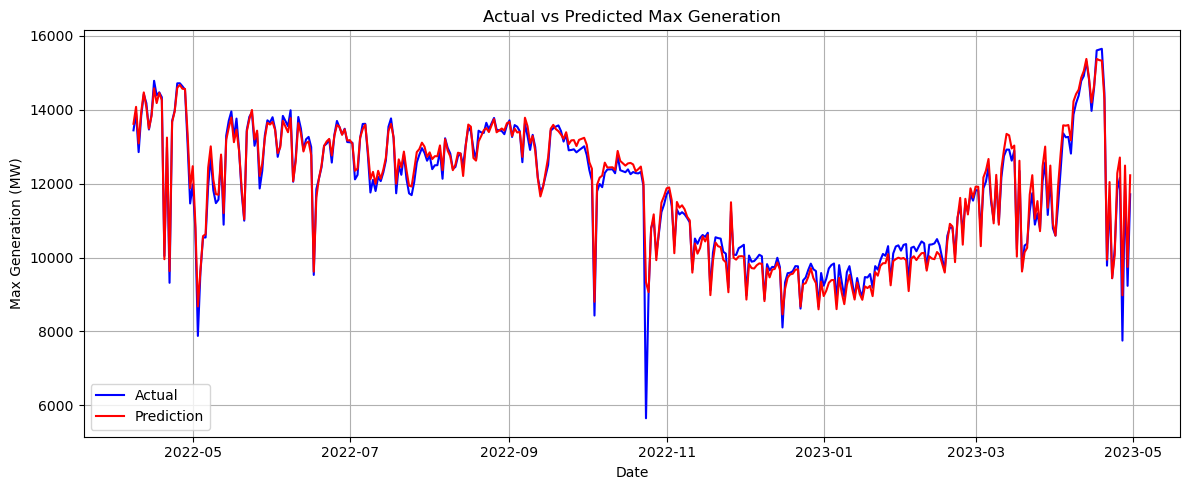

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(test_data.index, test_data["max_generation(mw)"], label="Actual", color="blue")
plt.plot(test_data.index, y_pred, label="Prediction", color="red")
plt.xlabel("Date")
plt.ylabel("Max Generation (MW)")
plt.title("Actual vs Predicted Max Generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculating the RMSE

In [31]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data["max_generation(mw)"], y_pred))
print(f"RMSE for max_generation(mw): {rmse}")

RMSE for max_generation(mw): 291.1920140774812


# Saving the model

In [32]:
final_model.save("final_model.h5")